## Họ và tên: Lương Khải Nguyên

# **1. Giới Thiệu**

- **Bối cảnh bài toán:**

    Dữ liệu gồm các cột:
    - `Ticker`: Mã cố phiếu (FPT, MSN, PNJ, và VIC).
    - `Date/Time`: Thời gian (`%m/%d/%Y %H:%M`).
    - `Open`: Giá mở cửa.
    - `High`: Giá cao nhất.
    - `Low`: Gía thấp nhất.
    - `Close`: Giá đóng cửa.
    - `Volume`: Khối lượng giao dịch.
    - `Open Interest`: Số hợp đồng mở (nếu có).


- **Mục tiêu:**

    Xây dựng mô hình dự đoán biến động giá cổ phiếu, biết công thức:

  
    `Biến động giá = Giá cổ phiếu 5 phút - Giá cổ phiếu hiện tại`.

# **2. Thư Viện Cần Thiết**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import mplfinance as mpf
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
import plotly.graph_objects as go

# **3. Tiền Xử Lý Dữ Liệu**

## 3.1 Đọc và kiểm tra dữ liệu 

Ta được cho 4 tập dữ liệu về cổ phiếu của 4 công ty lần lượt là: FPT, MSN, PNJ và VIC. Ta tiến hành gộp thành 1 tập dữ liệu để tiện cho việc xử lý.

In [8]:
df_fpt = pd.read_csv('FPT.csv')
df_msn = pd.read_csv('MSN.csv')
df_pnj = pd.read_csv('PNJ.csv')
df_vic = pd.read_csv('VIC.csv')

df = pd.concat([df_fpt, df_msn, df_pnj, df_vic], ignore_index=True)

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459335 entries, 0 to 459334
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         459335 non-null  object 
 1   Date/Time      459335 non-null  object 
 2   Open           459335 non-null  float64
 3   High           459335 non-null  float64
 4   Low            459335 non-null  float64
 5   Close          459335 non-null  float64
 6   Volume         459335 non-null  int64  
 7   Open Interest  459335 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 28.0+ MB
None
  Ticker        Date/Time   Open   High    Low  Close  Volume  Open Interest
0    FPT  12/25/2018 9:15  30.89  30.89  30.89  30.89   35410              0
1    FPT  12/25/2018 9:16  30.81  30.81  30.81  30.81     190              0
2    FPT  12/25/2018 9:17  30.74  30.81  30.74  30.74    1120              0
3    FPT  12/25/2018 9:18  30.74  30.74  30.74  30.74    2120   

Sau khi đọc `info` của các tập dữ liệu trên ta có thể thấy được dữ liệu không có giá trị `null`.

## 3.2 Chuyển đổi kiểu dữ liệu

Ta thấy cột `Date/Time` là chỉ thời gian và có định dạng `%m/%d/%Y %H:%M` nhưng lại có kiểu dữ liệu là `object` ta cần chuyển đổi kiểu dữ liệu sang dạng `datetime`.

In [12]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%m/%d/%Y %H:%M')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459335 entries, 0 to 459334
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Ticker         459335 non-null  object        
 1   Date/Time      459335 non-null  datetime64[ns]
 2   Open           459335 non-null  float64       
 3   High           459335 non-null  float64       
 4   Low            459335 non-null  float64       
 5   Close          459335 non-null  float64       
 6   Volume         459335 non-null  int64         
 7   Open Interest  459335 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 28.0+ MB
None


In [13]:
print(df['Date/Time'])

0        2018-12-25 09:15:00
1        2018-12-25 09:16:00
2        2018-12-25 09:17:00
3        2018-12-25 09:18:00
4        2018-12-25 09:19:00
                 ...        
459330   2020-12-22 14:22:00
459331   2020-12-22 14:23:00
459332   2020-12-22 14:24:00
459333   2020-12-22 14:25:00
459334   2020-12-22 14:46:00
Name: Date/Time, Length: 459335, dtype: datetime64[ns]


# **4. Khám Phá Dữ Liệu (EDA)**

## 4.1 Thống kê mô tả

Vì có 4 loại cổ phiếu nên ta thống kê mô tả trên từng loại cổ phiếu khác nhau.

In [17]:
print(df[df['Ticker'] == 'FPT'].describe())

                           Date/Time          Open          High  \
count                          97406  97406.000000  97406.000000   
mean   2020-01-21 05:08:51.739112192     45.071630     45.090138   
min              2018-12-25 09:15:00     30.250000     30.250000   
25%              2019-08-06 11:06:15     39.740000     39.740000   
50%              2020-01-31 10:37:30     46.950000     46.950000   
75%              2020-07-14 09:54:45     49.200000     49.250000   
max              2020-12-22 14:46:00     58.400000     58.500000   
std                              NaN      6.359803      6.364950   

                Low         Close        Volume  Open Interest  
count  97406.000000  97406.000000  9.740600e+04        97406.0  
mean      45.051430     45.071631  8.044173e+03            0.0  
min       30.220000     30.250000  1.000000e+01            0.0  
25%       39.700000     39.740000  7.500000e+02            0.0  
50%       46.950000     46.950000  2.960000e+03            0.0

**1. Cổ phiếu FPT:**

**Bản ghi:**  
- Có tổng cộng 97.406 giao dịch.

**Thời gian giao dịch (Date/Time):**  
- **Giá trị trung bình:** Khoảng 21/01/2020 05:08:51  
- **Khoảng thời gian:**  
  - **Min:** 25/12/2018  
  - **Max:** 22/12/2020  
- **Phân vị:**  
  - 25%: 06/08/2019 11:06:15  
  - 50% (median): 31/01/2020 10:37:30  
  - 75%: 14/07/2020 09:54:45  
Điều này cho biết dữ liệu giao dịch trải dài khá đều trong khoảng thời gian đã cho.

**Các biến giá (Open, High, Low, Close):**  
- **Giá trị trung bình:**  
  - Open: 45.07  
  - High: 45.09  
  - Low: 45.05  
  - Close: 45.07  
- **Khoảng giá:**  
  - **Min:** 30.25  
  - **Max:** 58.40 (Open) / 58.50 (High)  
- **Phân vị:**  
  - 25%: Khoảng 39.74  
  - 50% (median): 46.95  
  - 75%: Khoảng 49.20  
- **Độ lệch chuẩn:** Xấp xỉ 6.36 cho tất cả các biến giá  
Kết quả này cho thấy phần lớn các giao dịch có mức giá giao động từ khoảng 40 đến 50, với mức biến động (volatility) trung bình quanh 6.36 đơn vị so với giá trung bình.

**Volume (Khối lượng giao dịch):**  
- **Giá trị trung bình:** 8.044,17  
- **Độ lệch chuẩn:** Rất cao, khoảng 17.532,03  
- **Phân vị:**  
  - 25%: 750  
  - 50% (median): 2.960  
  - 75%: 8.960  
- **Khoảng giá:**  
  - **Min:** 10  
  - **Max:** 1.255.930  
Điều này cho thấy khối lượng giao dịch có sự phân bố lệch phải (right-skewed): phần lớn giao dịch có khối lượng thấp đến trung bình, nhưng tồn tại một số giao dịch với khối lượng rất lớn.

**Open Interest:**  
- Tất cả các giá trị đều bằng 0, cho thấy biến này không thay đổi và có thể không hữu ích cho việc phân tích mô hình (hoặc dữ liệu này không được cập nhật).

In [19]:
print(df[df['Ticker'] == 'MSN'].describe())

                           Date/Time           Open           High  \
count                         135354  135354.000000  135354.000000   
mean   2019-07-30 01:41:35.644310528      74.878809      74.931668   
min              2017-12-25 09:15:00      46.500000      46.500000   
25%              2018-10-16 13:15:15      57.900000      57.900000   
50%              2019-08-26 10:44:30      79.100000      79.200000   
75%              2020-05-12 13:20:45      86.000000      86.100000   
max              2020-12-22 14:46:00     117.800000     118.000000   
std                              NaN      15.418074      15.426954   

                 Low          Close        Volume  Open Interest  
count  135354.000000  135354.000000  1.353540e+05       135354.0  
mean       74.834625      74.880759  5.683578e+03            0.0  
min        46.400000      46.400000  1.000000e+01            0.0  
25%        57.800000      57.800000  5.000000e+02            0.0  
50%        79.100000      79.10000

**2. Cổ phiếu MSN:**

**Bản ghi:**  
  - Tổng số giao dịch: **135,354** bản ghi.

**Thời gian giao dịch (Date/Time):**  
  - **Giá trị trung bình:** Khoảng **2019-07-30 01:41:35**, cho thấy thời điểm giao dịch trung bình rơi vào giữa khoảng thời gian thu thập.  
  - **Khoảng thời gian:**  
    - **Bắt đầu:** 2017-12-25 09:15:00  
    - **Kết thúc:** 2020-12-22 14:46:00  
  - **Phân vị thời gian:**  
    - **25%:** 2018-10-16 13:15:15  
    - **50% (median):** 2019-08-26 10:44:30  
    - **75%:** 2020-05-12 13:20:45  
  Điều này cho thấy dữ liệu giao dịch được thu thập liên tục trong khoảng từ cuối năm 2017 đến cuối năm 2020, với phân bố thời gian khá đều.

**Các biến giá (Open, High, Low, Close):**  
  - **Giá trị trung bình:**  
    - Open: **74.88**  
    - High: **74.93**  
    - Low: **74.83**  
    - Close: **74.88**  
  - **Khoảng giá:**  
    - **Giá thấp nhất:** Khoảng **46.4 – 46.5**  
    - **Giá cao nhất:** Khoảng **117.8 – 118.0**  
  - **Phân vị:**  
    - **25%:** Khoảng **57.8 – 57.9**  
    - **50% (median):** Khoảng **79.1 – 79.2**  
    - **75%:** Khoảng **86.0 – 86.1**  
  - **Độ lệch chuẩn:** Xấp xỉ **15.42** cho tất cả các biến giá.  
  Điều này cho thấy các mức giá giao dịch có xu hướng tập trung quanh mức trung bình (khoảng 74-75) với mức biến động tương đối đồng nhất. Phân vị rõ ràng từ 25% đến 75% cho thấy sự thay đổi giá trong mỗi phiên giao dịch khá ổn định.

**Khối lượng giao dịch (Volume):**  
  - **Giá trị trung bình:** **5,683.58**  
  - **Khoảng giao dịch:**  
    - **Min:** 10  
    - **Max:** 3,300,680  
  - **Phân vị:**  
    - **25%:** 500  
    - **50% (median):** 2,000  
    - **75%:** 5,560  
  - **Độ lệch chuẩn:** Xấp xỉ **27,985.13**  
  Điều này cho thấy khối lượng giao dịch phân bố lệch phải: phần lớn các giao dịch có khối lượng từ thấp đến trung bình, nhưng tồn tại một số giao dịch có khối lượng cực lớn, kéo độ lệch chuẩn lên mức rất cao.

**Open Interest:**  
  - Tất cả các bản ghi đều có giá trị bằng **0**, cho thấy feature này không có giá trị sử dụng cho các phân tích sâu hơn hoặc mô hình dự đoán.

Bạn có thể copy đoạn Markdown trên vào Jupyter Notebook để trình bày kết quả phân tích một cách rõ ràng và chuyên nghiệp.

In [21]:
print(df[df['Ticker'] == 'PNJ'].describe())

                           Date/Time           Open           High  \
count                         125309  125309.000000  125309.000000   
mean   2019-08-19 13:55:12.292173568      72.182052      72.372590   
min              2018-02-28 09:15:00      44.430000      44.530000   
25%              2018-11-15 11:10:00      64.600000      64.700000   
50%              2019-09-05 09:51:00      72.800000      73.010000   
75%              2020-05-11 14:22:00      80.160000      80.350000   
max              2020-12-22 14:46:00     100.160000     100.160000   
std                              NaN       9.900263       9.995786   

                 Low          Close         Volume  Open Interest  
count  125309.000000  125309.000000  125309.000000       125309.0  
mean       72.042287      72.179371    3031.830451            0.0  
min        44.040000      44.140000       1.000000            0.0  
25%        64.570000      64.600000     220.000000            0.0  
50%        72.640000      72.

**3. Cổ phiếu PNJ:**

Dựa vào bảng số liệu, ta có:
- **Bản ghi**: 125309.
- **Thời gian giao dịch (Date/Time):**
    - **Giá trị trung bình:** Khoảng 19/08/2019 13:55:12 cho thấy thời điểm giao dịch trung bình.
    - **Khoảng thời gian:** Từ 28/02/2018 đến 22/12/2020.
    - **Phân vị:**
      - 25%: 15/11/2018 11:10:00.
      - 50% (median): 05/09/2019 09:51:00.
      - 75%: 11/05/2020 14:22:00.
    Điều này cho thấy dữ liệu giao dịch cổ phiếu PNJ trải dài khá đều trong khoảng thời gian đã cho.

- **Các biến giá (Open, High, Low, Close)**:
    - **Giá trị trung bình:**
      - Open: 72.18.
      - High: 72.37.
      - Low: 72.04.
      - Close: 72.18.
    - **Khoảng giá**: Từ khoảng 44.04 đến 100.16.
    - **Phân vị:**
      - 25%: Khoảng 64.60 (Open), 64.70 (High), 64.57 (Low), 64.60 (Close).
      - 50%: Khoảng 72.80 (Open), 73.01 (High), 72.64 (Low), 72.83 (Close).
      - 75%: Khoảng 80.16 (Open), 80.35 (High), 80.06 (Low), 80.16 (Close).
    - **Độ lệch chuẩn:** Xấp xỉ từ 9.90 đến 9.99 cho các biến giá.
    Kết quả cho thấy phần lớn các giao dịch có mức giá giao dịch từ khoảng 64.6 đến 80.2 với mức biến động trung bình quanh 9.9 đơn vị so với giá trung bình.

- **Khối lượng giao dịch (Volume):**
    - **Giá trị trung bình:** 3031.83.
    - **Khoảng Volume:** Từ 1 đến 580730.
    - **Độ lệch chuẩn:** Rất cao, khoảng 7248.95.
    - **Phân vị:**
      - 25%: 220.
      - 50%: 1000.
      - 75%: 3130.
    Điều này cho thấy khối lượng giao dịch có sự phân bố lệch phải (right-skewed): Phần lớn giao dịch có khối lượng từ thấp đến trung bình, nhưng lại tồn tại một số giao dịch có khối lượng rất cao.

- **Open Interest:** Tất cả các bản ghi đều có giá trị bằng 0, điều này có thể cho thấy rằng feature này không có giá trị cho việc xây dựng mô hình dự đoán.

In [23]:
print(df[df['Ticker'] == 'VIC'].describe())

                           Date/Time           Open           High  \
count                         101266  101266.000000  101266.000000   
mean   2019-12-05 15:50:51.577627392     105.376460     105.418519   
min              2018-10-17 09:39:00      68.000000      68.000000   
25%              2019-05-16 13:29:15      95.400000      95.400000   
50%              2019-12-13 11:09:30     105.300000     105.300000   
75%              2020-06-25 10:28:45     115.800000     115.900000   
max              2020-12-22 14:46:00     126.100000     126.500000   
std                              NaN      11.543158      11.535584   

                 Low          Close        Volume  Open Interest  
count  101266.000000  101266.000000  1.012660e+05       101266.0  
mean      105.334147     105.378791  3.182640e+03            0.0  
min        68.000000      68.000000  1.000000e+01            0.0  
25%        95.300000      95.400000  2.300000e+02            0.0  
50%       105.200000     105.30000

**4. Cổ phiếu VIC:**

Dựa vào bảng số liệu, ta có:
- **Bản ghi**: 101266.
- **Thời gian giao dịch (Date/Time):**
    - **Giá trị trung bình:** Khoảng 05/12/2019 15:50:51 cho thấy thời điểm giao dịch trung bình.
    - **Khoảng thời gian:** Từ 17/10/2018 09:39:00 đến 22/12/2020 14:46:00.
    - **Phân vị:**
      - 25%: 16/05/2019 13:29:15.
      - 50% (median): 13/12/2019 11:09:30.
      - 75%: 25/06/2020 10:28:45.
    Điều này cho thấy dữ liệu giao dịch cổ phiếu VIC được thu thập liên tục và phân bố đều trong khoảng thời gian đã cho.

- **Các biến giá (Open, High, Low, Close)**:
    - **Giá trị trung bình:**
      - Open: 105.38.
      - High: 105.42.
      - Low: 105.33.
      - Close: 105.38.
    - **Khoảng giá**: Từ khoảng 68 đến 126.1 (với Open) và từ 68 đến 126.5 (với High, Close).
    - **Phân vị:**
      - 25%: Khoảng 95.4 (Open, High), 95.3 (Low) và 95.4 (Close).
      - 50%: Khoảng 105.3 cho tất cả các biến.
      - 75%: Khoảng 115.8 (Open, Low, Close) và 115.9 (High).
    - **Độ lệch chuẩn:** Xấp xỉ 11.54 cho tất cả các biến giá.
    Kết quả cho thấy phần lớn các giao dịch có mức giá giao dịch tập trung quanh 105 với độ biến động trung bình khoảng 11.54 đơn vị, và giá phân bố từ khoảng 95 đến 115 tại các phân vị chính.

- **Khối lượng giao dịch (Volume):**
    - **Giá trị trung bình:** 3182.64.
    - **Khoảng Volume:** Từ 10 đến 1,468,390.
    - **Độ lệch chuẩn:** Xấp xỉ 14698.14.
    - **Phân vị:**
      - 25%: 230.
      - 50%: 1020.
      - 75%: 3000.
    Điều này cho thấy khối lượng giao dịch có sự phân bố lệch phải (right-skewed): phần lớn giao dịch có khối lượng từ thấp đến trung bình, nhưng tồn tại một số giao dịch có khối lượng rất cao.

- **Open Interest:** Tất cả các bản ghi đều có giá trị bằng 0, điều này cho thấy rằng feature này không có giá trị cho việc xây dựng mô hình dự đoán.


## 4.2 Trực quan hóa dữ liệu

Vì **giá đóng cửa** phản ánh "kết thúc" của một phiên giao dịch, khi tâm lý thị trường đã được thể hiện qua sự giao dịch trong ngày. Điều này giúp loại bỏ nhiễu loạn từ biến động ngắn hạn và cho phép theo dõi xu hướng của một cổ phiếu một cách rõ ràng hơn. Nên vì thế ta sẽ trực quan hóa giá đóng của 4 công ty.

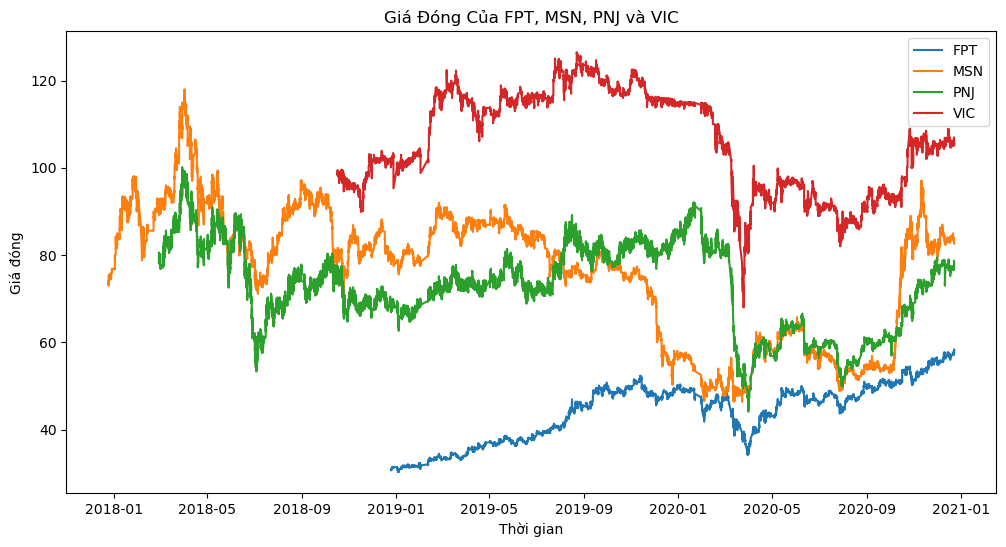

In [27]:
tickers = ['FPT', 'MSN', 'PNJ', 'VIC']

plt.figure(figsize=(12,6))
for ticker in df['Ticker'].unique():
    subset = df[df['Ticker'] == ticker]
    plt.plot(subset['Date/Time'], subset['Close'], label=ticker)
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng')
plt.title('Giá Đóng Của FPT, MSN, PNJ và VIC')
plt.legend()
plt.show()

Biểu đồ trên thể hiện **giá đóng cửa** (close) của bốn cổ phiếu FPT, MSN, PNJ và VIC trong giai đoạn từ khoảng **đầu năm 2018 đến đầu năm 2021**. Dưới đây là một số quan sát chung:

1. **Xu hướng chung**  
   - **FPT (màu xanh dương)**: Có xu hướng tăng khá đều từ năm 2018 đến 2021, với biên độ dao động không quá mạnh.  
   - **MSN (màu cam)**: Từ giai đoạn 2018–2019 có mức giá tương đối cao, sau đó giảm trong năm 2019 và đặc biệt là giai đoạn đầu 2020. Tuy nhiên, cuối 2020 – đầu 2021 có dấu hiệu hồi phục.  
   - **PNJ (màu xanh lá)**: Giữ mức giá khá cao trong năm 2018, dao động tương đối lớn. Tới năm 2020, giá giảm mạnh (phản ánh tác động chung của thị trường) và sau đó bắt đầu phục hồi.  
   - **VIC (màu đỏ)**: Có mức giá cao nhất so với ba cổ phiếu còn lại. Trong năm 2018–2019, VIC tăng từ khoảng 70 lên trên 100, rồi dao động khá lớn trong năm 2020, nhưng cuối cùng vẫn duy trì trên ngưỡng 90–100.

2. **Tác động của thị trường chung**  
   - Bạn có thể thấy rõ cú giảm mạnh vào đầu năm 2020 (trùng với thời điểm thị trường toàn cầu chịu ảnh hưởng bởi đại dịch). Sau đó, các cổ phiếu này bắt đầu quá trình phục hồi dần vào nửa cuối năm 2020.

3. **Biên độ dao động**  
   - VIC và PNJ có biên độ dao động giá tương đối lớn trong giai đoạn này, trong khi FPT có xu hướng tăng ổn định hơn. MSN dao động mạnh trong năm 2019 và đặc biệt năm 2020.

4. **Kết luận ban đầu**  
   - Nhìn chung, biểu đồ cho thấy mỗi cổ phiếu có đặc thù biến động riêng, nhưng đều chịu ảnh hưởng rõ rệt từ biến động chung của thị trường (đặc biệt trong giai đoạn đầu 2020).

Ta sẽ tiến hành trực quan hóa sự phân phối của khối lượng giao dịch (Volume) theo thời gian. Nhưng vì thời gian của dữ liệu là theo từng phút (quá lớn) nên rất khó trực quan nên ta sẽ tiến hành resample dữ liệu lại theo tháng và tiến hành phân tích Volume của từng cổ phiếu.

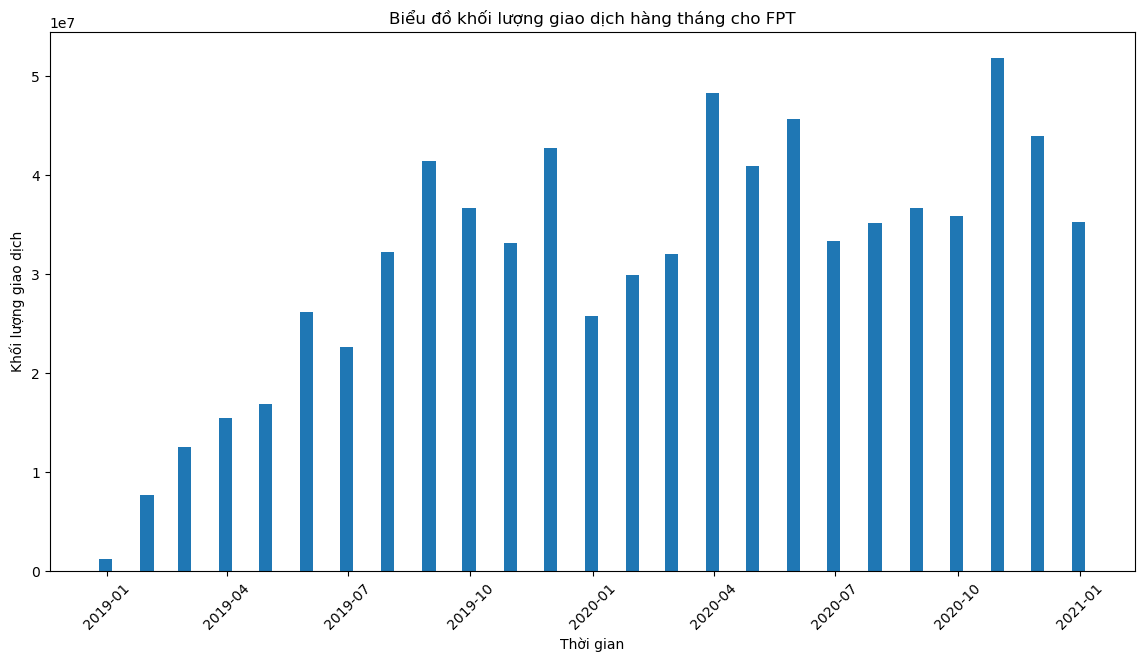

In [30]:
df_ticker = df[df['Ticker'] == 'FPT'].copy(deep=True)
df_ticker.set_index('Date/Time', inplace=True)
df_daily = df_ticker.resample('ME').sum()

plt.figure(figsize=(14, 7))
plt.bar(df_daily.index, df_daily['Volume'], width=10)
plt.xlabel('Thời gian')
plt.ylabel('Khối lượng giao dịch')
plt.title(f'Biểu đồ khối lượng giao dịch hàng tháng cho FPT')
plt.xticks(rotation=45)
plt.show()

**Cổ phiếu FPT:**
  
Dựa trên biểu đồ, ta có nhận xét:

1. **Xu hướng tăng dần qua các tháng:**
    Nhìn vào biểu đồ ta có thể thấy được cổ phiếu FPT có xu hướng tăng dần từ đầu giai đoạn (tháng 01/2019) đến các tháng tiếp theo, thậm chí tới tháng 11/2020 (đỉnh điểm). Điều này cho thấy cổ phiếu FPT nhận được sự quan tâm từ các nhà đầu tư.
2. **Mức độ biến động theo thời gian:**
    - Trong những tháng đầu (từ tháng 01 trở đi) của các năm, thì khối lượng giao dịch bắt đầu tăng dân đều, cho thấy đà giao dịch được đẩy lên đều.
    - Các tháng từ tháng 04 trở đi thì các giao dịch được đẩy mạnh hơn, và đỉnh điểm là giao dịch rất cao ở những dịp cuối năm, điều này có thể phản ánh các thời điểm thị trường phản ứng với tin tức của FPT. Nhưng qua năm mới (tức những tháng đầu) thì khối lượng bắt đầu giảm đáng kể so với cuối năm và lại bắt đầu tăng dần.
3. **Khả năng duy trì thanh khoản:**
    Khối lượng giao dịch cao và đều theo từng năm có thể phản ánh và cho thấy tính thanh khoản tốt của cổ phiếu FPT. Điều này thu hút cả nhà đầu tư ngắn hạn (lướt sóng) lẫn nhà đầu tư dài hạn, vì cổ phiếu có khả năng mua/bán dễ dàng.
4. **Góc nhìn đầu tư:**
    Khối lượng tăng dần và duy trì ở mức cao cho thấy FPT có sức hút tốt, và có thể kỳ vọng sự tích cưc của thị trường.

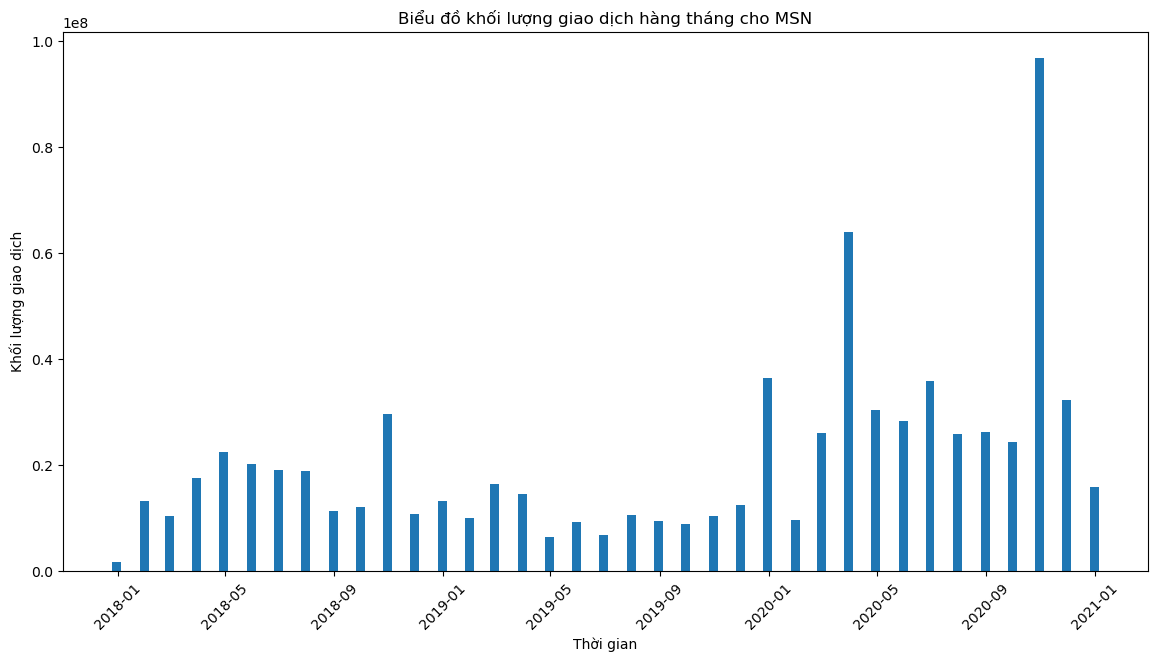

In [32]:
df_ticker = df[df['Ticker'] == 'MSN'].copy(deep=True)
df_ticker.set_index('Date/Time', inplace=True)
df_daily = df_ticker.resample('ME').sum()

plt.figure(figsize=(14, 7))
plt.bar(df_daily.index, df_daily['Volume'], width=10)
plt.xlabel('Thời gian')
plt.ylabel('Khối lượng giao dịch')
plt.title(f'Biểu đồ khối lượng giao dịch hàng tháng cho MSN')
plt.xticks(rotation=45)
plt.show()

**Cổ phiếu MSN:**

Dựa trên biểu đồ, ta có nhận xét:

1. **Xu hướng khối lượng qua các năm:**
    - Ta thấy từ các năm 2018 đến cuối 2019, cổ phiếu MSN có sự ổn định (thậm chí là giảm, không có sự tăng trưởng đáng kể). Điều này cho thấy thị trường có mức độ quan tâm vừa phải, thậm chí có 1 chút giảm với MSN.
    - Đầu năm 2020 (tháng 01), khối lượng giao dịch đột nhiên tăng mạnh sau đó giảm mạnh xuống mức rấp thấp ở tháng 02, nhưng sau đó lại tăng mạnh, giảm nhẹ và tăng dần tới đỉnh điểm vào tháng 10 năm 2020. Điều này cho thấy thị trường bắt đầu quan tâm tới MSN, lý giải cho điều này có thể là do tin tức hay báo cáo tài chính đến từ MSN khiến các nhà đầu tư quan tâm mạnh hơn.
2. **Duy trì thanh khoản:**
   Khối lượng giao dịch của MSN cũng ở mức trung bình cao và đều đặn, không có quá nhiều sự đột biến. Cho thấy thanh khoản cũng đều đặn, thu hút các nhà đầu tư. 

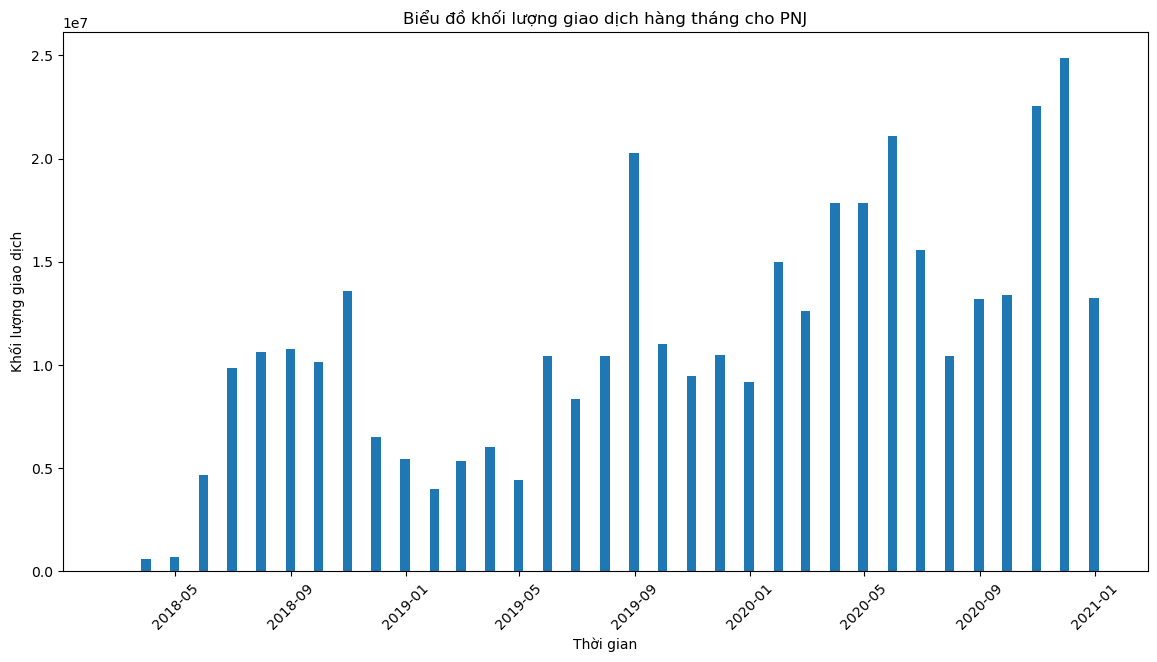

In [34]:
df_ticker = df[df['Ticker'] == 'PNJ'].copy(deep=True)
df_ticker.set_index('Date/Time', inplace=True)
df_daily = df_ticker.resample('ME').sum()

plt.figure(figsize=(14, 7))
plt.bar(df_daily.index, df_daily['Volume'], width=10)
plt.xlabel('Thời gian')
plt.ylabel('Khối lượng giao dịch')
plt.title(f'Biểu đồ khối lượng giao dịch hàng tháng cho PNJ')
plt.xticks(rotation=45)
plt.show()

**Cổ phiếu PNJ:**

1. **Xu hướng khối lượng qua các tháng:**
    - Giữa 2018 đến giữa 2019: Khối lượng giao dịch có vẻ ổn định, không có mức dao động quá lớn hay đột biến đáng kể.
    - Từ tháng 08/2019 trở đi: Khối lượng giao dịch đột nhiên tăng mạnh, và bắt đầu tăng dần từ đó trở đi. Cho thấy nhà đầu tư có thể quan tâm hơn đến PNJ nhiều hơn là năm 2018. Hay điều này có thể dính đến sản phẩm, hay thông tin tích cực đến từ PNJ.
2. **Duy trì thanh khoản:**
    - Trong suốt giai đoạn 2018-2021, khối lượng nhìn chung có xu hướng tăng, thể hiện cổ phiếu PNJ ngày càng được quan tâm, thanh khoản được cải thiện.
    - Nếu sau những đột biến khối lượng, mức khối lượng vẫn cao thì chứng tỏ thị trường duy trì sự chú ý đến PNJ, giúp việc mua/bán cổ phiếu trở nên dễ dàng hơn (thanh khoản cao).

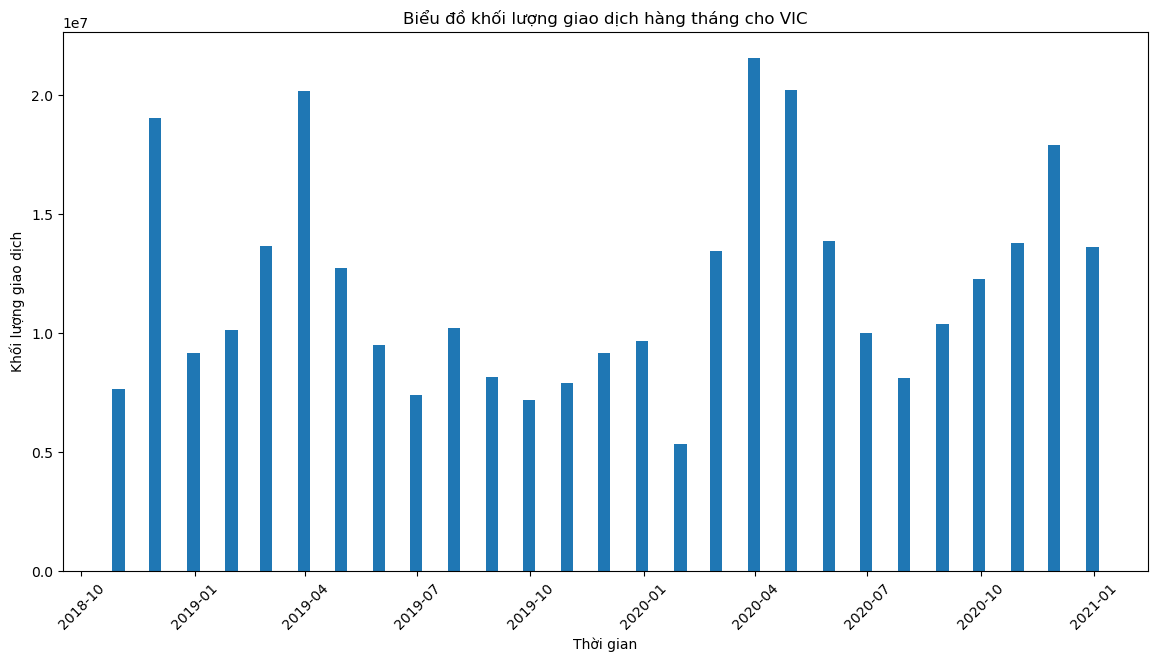

In [36]:
df_ticker = df[df['Ticker'] == 'VIC'].copy(deep=True)
df_ticker.set_index('Date/Time', inplace=True)
df_daily = df_ticker.resample('ME').sum()

plt.figure(figsize=(14, 7))
plt.bar(df_daily.index, df_daily['Volume'], width=10)
plt.xlabel('Thời gian')
plt.ylabel('Khối lượng giao dịch')
plt.title(f'Biểu đồ khối lượng giao dịch hàng tháng cho VIC')
plt.xticks(rotation=45)
plt.show()

**Cổ phiếu VIC:**

1. **Xu hướng khối lượng:**
    - Cuối năm 2018: Khối lượng tăng cao, cho thấy nhà đầu tư quan tâm đến VIC.
    - Đầu năm 2019: Khối lượng giao dịch giảm hẳn và bắt đầu tăng dần đến đỉnh điểm (tháng 04/2019). Điều này cho thấy nhà đầu tư bắt đầu chú ý hơn, có thể do VIC công bố các dự án mới, kết quả kinh doanh tích cực hoặc những tin tức quan trọng về hoạt động kinh doanh. Nhưng sau đó sự quan tâm bắt đầu giảm dần khiến khối lượng giao dịch về đều như cũ.
    - Đầu năm 2020 trở đi: Khối lượng giao dịch lúc này mới tăng mạnh và liên tục trong mấy tháng, bắt đầu giảm dần vào gần cuối năm nhưng sau đó lại tăng lại đáng kể. Những biến động này thường gắn liền với sự kiện lớn
2. **Duy trì thanh khoản:**
    - Nhìn chung, VIC có khối lượng giao dịch khá cao và ổn định trong suốt giai đoạn, chỉ có một số tháng giảm nhẹ, sau đó tăng trở lại. Điều này thể hiện cổ phiếu VIC có tính thanh khoản tốt, được nhiều nhà đầu tư quan tâm.
    - Thanh khoản tốt giúp nhà đầu tư mua/bán dễ dàng, ít rủi ro bị trượt giá lớn khi có lệnh giao dịch khối lượng cao.

# **5. Feature Engineering**

Vì toàn bộ giá trị của cột `Open Interest` đều là 0 và không có giá trị sử dụng để xây dựng mô hình nên ta sẽ bỏ luôn cột đó.

In [40]:
df.drop('Open Interest', axis=1, inplace=True)

Vì ta xây dựng mô hình dự đoán biến động giá cổ phiếu N phút (N = 5) nên ta sẽ chuẩn hóa lại dữ liệu theo từng phút.

In [42]:
df.set_index('Date/Time', inplace=True)

In [43]:
def resample_and_fill(group):
    group = group.resample('1min').asfreq()
    group['Ticker'] = group['Ticker'].ffill()
    return group

df = df.groupby('Ticker', group_keys=False).apply(resample_and_fill)
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df[numeric_cols] = df.groupby('Ticker', group_keys=False)[numeric_cols].apply(lambda x: x.interpolate(method='linear'))

C:\Users\nkluo\AppData\Local\Temp\ipykernel_11908\2144698685.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Ticker', group_keys=False).apply(resample_and_fill)


In [44]:
print(df.isnull().sum())

Ticker    0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


Sau khi đã chuẩn hóa dữ liệu theo từng phút và nội suy dữ liệu (dự đoán) để có thể điền vào những đoạn dữ liệu không liên tục hay không đồng đều, thì ta sẽ tạo biến mục tiêu thể hiện biến động giá cổ phiếu (N = 5) phút.

In [46]:
N = 5
df['Target'] = df.groupby('Ticker')['Close'].shift(-N) - df['Close']
df['Target']

Date/Time
2018-12-25 09:15:00   -0.150000
2018-12-25 09:16:00   -0.150000
2018-12-25 09:17:00   -0.079686
2018-12-25 09:18:00   -0.079372
2018-12-25 09:19:00   -0.079059
                         ...   
2020-12-22 14:42:00         NaN
2020-12-22 14:43:00         NaN
2020-12-22 14:44:00         NaN
2020-12-22 14:45:00         NaN
2020-12-22 14:46:00         NaN
Name: Target, Length: 5251544, dtype: float64

In [47]:
df.isnull().sum()

Ticker     0
Open       0
High       0
Low        0
Close      0
Volume     0
Target    20
dtype: int64

Vì số lượng null quá ít $20/5251544 \approx 3.808*10^-6 (\%)$, nên ta sẽ loại bỏ 20 dòng này.

In [49]:
df.dropna(inplace=True)
df.isnull().sum()

Ticker    0
Open      0
High      0
Low       0
Close     0
Volume    0
Target    0
dtype: int64

Ta sẽ tiến hành tính `Range`, tức phạm vi giá của cổ phiếu.

In [51]:
df['Range'] = df['High'] - df['Low']
print(df['Range'])

Date/Time
2018-12-25 09:15:00    0.00
2018-12-25 09:16:00    0.00
2018-12-25 09:17:00    0.07
2018-12-25 09:18:00    0.00
2018-12-25 09:19:00    0.00
                       ... 
2020-12-22 14:37:00    0.00
2020-12-22 14:38:00    0.00
2020-12-22 14:39:00    0.00
2020-12-22 14:40:00    0.00
2020-12-22 14:41:00    0.00
Name: Range, Length: 5251524, dtype: float64


Sau đó, ta cũng tiến hành tính được lợi nhuận từng phút.

In [53]:
df['Return'] = df.groupby('Ticker')['Close'].transform(lambda x: x.pct_change())
print(df['Return'])

Date/Time
2018-12-25 09:15:00         NaN
2018-12-25 09:16:00   -0.002590
2018-12-25 09:17:00   -0.002272
2018-12-25 09:18:00    0.000000
2018-12-25 09:19:00    0.000000
                         ...   
2020-12-22 14:37:00    0.000000
2020-12-22 14:38:00    0.000000
2020-12-22 14:39:00    0.000000
2020-12-22 14:40:00    0.000000
2020-12-22 14:41:00    0.000000
Name: Return, Length: 5251524, dtype: float64


In [54]:
df.isnull().sum()

Ticker    0
Open      0
High      0
Low       0
Close     0
Volume    0
Target    0
Range     0
Return    4
dtype: int64

Ta thấy có 4 dòng là bị giá trị null, 4 dòng này chính là nơi bắt đầu của data của mỗi cổ phiếu, nên ta có thể gán 4 dòng này với giá trị là 0 cho đơn giản.

In [56]:
df.fillna(0.0, inplace=True)

Ta sẽ tạo thêm một feature nữa là trung bình động 5 (Moving Average 5), tức là tính trung bình giá đóng cửa 5 phiên gần nhất.

In [58]:
df['MA_5'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=5).mean())
print(df['MA_5'])
print(df.isnull().sum())

Date/Time
2018-12-25 09:15:00        NaN
2018-12-25 09:16:00        NaN
2018-12-25 09:17:00        NaN
2018-12-25 09:18:00        NaN
2018-12-25 09:19:00     30.784
                        ...   
2020-12-22 14:37:00    105.700
2020-12-22 14:38:00    105.700
2020-12-22 14:39:00    105.700
2020-12-22 14:40:00    105.700
2020-12-22 14:41:00    105.700
Name: MA_5, Length: 5251524, dtype: float64
Ticker     0
Open       0
High       0
Low        0
Close      0
Volume     0
Target     0
Range      0
Return     0
MA_5      16
dtype: int64


Vì là MA_5 nên khi tính thì 4 giá trị đầu sẽ là NaN, để đơn giản hóa vấn đề ta sẽ dùng phương pháp forward fill để điền vào các ô có giá trị NaN.

In [60]:
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

C:\Users\nkluo\AppData\Local\Temp\ipykernel_11908\3964524321.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\nkluo\AppData\Local\Temp\ipykernel_11908\3964524321.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [61]:
df.isnull().sum()

Ticker    0
Open      0
High      0
Low       0
Close     0
Volume    0
Target    0
Range     0
Return    0
MA_5      0
dtype: int64

Ta sẽ tiến hành biến cột `Ticker` thành dạng số bằng phương pháp LabelEncoder, biến thành 0, 1, 2...

In [63]:
le = LabelEncoder()
df["Ticker_encoded"] = le.fit_transform(df["Ticker"])

In [64]:
df.isnull().sum()

Ticker            0
Open              0
High              0
Low               0
Close             0
Volume            0
Target            0
Range             0
Return            0
MA_5              0
Ticker_encoded    0
dtype: int64

# **6. Xây Dựng Mô Hình**

## 6.1 Chia tập dữ liệu

Đầu tiên ta sẽ chia tập dữ liệu theo tỷ lệ $80:20$.

In [68]:
X = df.drop(['Target', 'Ticker'], axis=1)
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 6.2 Mô hình Hồi Quy Tuyến Tính

Đầu tiên ta sẽ xây dựng mô hình **Hồi Quy Tuyến Tính cơ bản (Linear Regression)**.

In [71]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

print("Hồi quy tuyến tính:")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", mean_squared_error(y_test, y_pred_lr, squared=False))

Hồi quy tuyến tính:
MAE: 0.027335423074266552
RMSE: 0.12393143278157896


C:\Users\nkluo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


 Mô hình **Hồi Quy Tuyến Tính** đạt được các kết quả sau:  
- **MAE = 0.0273**: Trung bình sai số tuyệt đối giữa giá dự đoán và giá thực tế là 0.0273.  
- **RMSE = 0.1239**: Sai số trung bình bình phương gốc cho thấy mức độ phân tán của lỗi dự đoán.  

**Đánh giá:**  
- Với dữ liệu tài chính, MAE thấp cho thấy mô hình dự đoán khá chính xác, nhưng RMSE vẫn có khoảng chênh lệch đáng kể, có thể bị ảnh hưởng bởi một số dự đoán sai lệch lớn.  
- Do cổ phiếu có tính biến động cao trong thời gian ngắn, hồi quy tuyến tính có thể chưa đủ mạnh để nắm bắt các xu hướng phi tuyến phức tạp.

Việc sử dụng các **mô hình phi tuyến** có thể giúp cải thiện khả năng dự báo, đặc biệt là đối với các biến động bất thường.

## 6.3 Mô hình phi tuyến tính Hist Gradient Boosting Regressor

Sau khi thử nghiệm với mô hình tuyến tính ta sẽ thử mô hình phi tuyến tính xem sao.

In [75]:
model_hgb = HistGradientBoostingRegressor(random_state=42)
model_hgb.fit(X_train, y_train)
y_pred_hgb = model_hgb.predict(X_test)

print("Gradient Boosting Regressor:")
print("MAE:", mean_absolute_error(y_test, y_pred_hgb))
print("RMSE:", mean_squared_error(y_test, y_pred_hgb, squared=False))

Gradient Boosting Regressor:
MAE: 0.02249847058921263
RMSE: 0.12345269886526641


C:\Users\nkluo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Kết luận:**

Mô hình **Gradient Boosting Regressor** cho **MAE** thấp hơn so với mô hình **Hồi quy tuyến tính** (**0.0225** so với **0.0273**), điều này cho thấy trung bình dự báo sai số nhỏ hơn. Tuy nhiên, **RMSE** vẫn tương đối cao **(0.12345)**, chỉ ra rằng mặc dù đa số các dự báo có sai số nhỏ, vẫn có một số trường hợp dự báo lệch lớn. Điều này phản ánh tính biến động phi tuyến và khó lường của dữ liệu chứng khoán. Do đó, mô hình này cho thấy một bước tiến nhỏ trong việc cải thiện độ chính xác trung bình nhưng vẫn cần phải giải quyết vấn đề sai số lớn trong một số trường hợp, có thể thông qua việc tối ưu hoá thêm hoặc kết hợp với các mô hình khác (ensemble) để đạt được kết quả dự báo ổn định hơn.

## 6.4 Mô hình XGBoost Regressor

Ta sẽ thử với mô hình XGBoost Regressor.

In [79]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

print("XGBoost Regressor:")
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", mean_squared_error(y_test, y_pred_xgb, squared=False))

XGBoost Regressor:
MAE: 0.022904168997660887
RMSE: 0.12065985947305252


C:\Users\nkluo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Kết luận:**

Mô hình **XGBoost Regressor** cho **MAE** ở mức khoảng **0.0229**, cho thấy sai số trung bình của các dự báo là tương đối thấp. **RMSE** là **0.12066**, thấp hơn một chút so với một số mô hình khác, chỉ ra rằng sự phân bố của các lỗi dự báo có xu hướng ổn định hơn và các sai số lớn có thể đã được giảm thiểu. Như vậy, **XGBoost Regressor** cho kết quả dự báo tương đối tốt cho bài toán dự đoán biến động giá cổ phiếu, đặc biệt khi so sánh với các mô hình khác như **Hồi quy tuyến tính** và **Gradient Boosting (HistGBR)**. Tuy nhiên, vẫn cần chú ý đến các trường hợp dự báo lệch lớn (được thể hiện qua **RMSE**), nên có thể xem xét việc tối ưu thêm hoặc **kết hợp** với các mô hình khác (ensemble) nhằm nâng cao hiệu quả dự báo tổng thể.

## 6.5 Xây dựng Stacking Ensemble

Ở đây, chúng ta kết hợp các mô hình cơ sở đã huấn luyện bằng một meta-model (Linear Regression) sử dụng kỹ thuật stacking.

In [83]:
base_models = [
    ('lr', model_lr),
    ('hgb', model_hgb),
    ('xgb', model_xgb)
]

meta_model = LinearRegression()
stacking_reg = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

stacking_reg.fit(X_train, y_train)
y_pred_stack = stacking_reg.predict(X_test)

print("Stacking Ensemble Model:")
print("MAE:", mean_absolute_error(y_test, y_pred_stack))
print("RMSE:", mean_squared_error(y_test, y_pred_stack, squared=False))

Stacking Ensemble Model:
MAE: 0.0237795921604969
RMSE: 0.11954734478151294


C:\Users\nkluo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mô hình **Stacking Ensemble** đạt kết quả sau:

- **MAE:** 0.02378  
- **RMSE:** 0.11955

**Kết luận:**

- **Độ chính xác:**  
  Mô hình Stacking Ensemble cho sai số trung bình (MAE) khoảng 0.02378, tương đương với sai số trung bình khá thấp so với giá trị của biến mục tiêu (đã được chuẩn hóa hoặc tính theo tỷ lệ phần trăm). 

- **Hiệu quả xử lý các sai số lớn:**  
  Với RMSE là 0.11955, mô hình này đã giảm được các trường hợp sai lệch lớn so với một số mô hình đơn lẻ (so với XGBoost hoặc HistGBR riêng lẻ). Điều này cho thấy việc kết hợp các dự báo từ nhiều mô hình cơ sở đã giúp tăng cường khả năng dự báo ổn định hơn, đặc biệt đối với các biến động phi tuyến hoặc những trường hợp ngoại lệ.

- **Nhận xét chung:**  
  Mặc dù MAE của Stacking Ensemble hơi cao so với XGBoost (0.02290) nhưng RMSE thấp hơn, điều này cho thấy mô hình ensemble có khả năng giảm thiểu tác động của những sai số lớn. Đây là một kết quả khả quan cho bài toán dự báo biến động giá cổ phiếu, đồng thời mở ra hướng tối ưu hoá thêm bằng cách điều chỉnh các siêu tham số của các mô hình cơ sở và meta-model.

Như vậy, mô hình Stacking Ensemble đã đạt được hiệu suất dự báo tốt trong việc dự đoán biến động giá cổ phiếu, với khả năng tổng hợp điểm mạnh của các mô hình đơn lẻ để giảm các sai số bất thường.